In [14]:
import numpy as np
import pandas as pd
import requests
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
from datetime import datetime, timedelta
import yfinance as yf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
btc_ticker = yf.Ticker("BTC-USD")

In [3]:
if os.path.exists("btc.csv"):
    btc = pd.read_csv("btc.csv", index_col=0)
else:
    btc = btc_ticker.history(period="max")
    btc.to_csv("btc.csv")

In [4]:
btc

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-06 00:00:00+00:00,71082.843750,71625.734375,70119.125000,70757.164062,25223152007,0.0,0.0
2024-06-07 00:00:00+00:00,70759.187500,71907.851562,68507.257812,69342.585938,36188381096,0.0,0.0
2024-06-08 00:00:00+00:00,69324.179688,69533.320312,69210.742188,69305.773438,14262185861,0.0,0.0


In [5]:
btc.index = pd.to_datetime(btc.index)
del btc["Dividends"]
del btc["Stock Splits"]
btc.columns = [c.lower() for c in btc.columns]
btc

,open,high,low,close,volume
Date,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100
...,...,...,...,...,...
2024-06-06 00:00:00+00:00,71082.843750,71625.734375,70119.125000,70757.164062,25223152007
2024-06-07 00:00:00+00:00,70759.187500,71907.851562,68507.257812,69342.585938,36188381096
2024-06-08 00:00:00+00:00,69324.179688,69533.320312,69210.742188,69305.773438,14262185861


<Axes: xlabel='Date'>

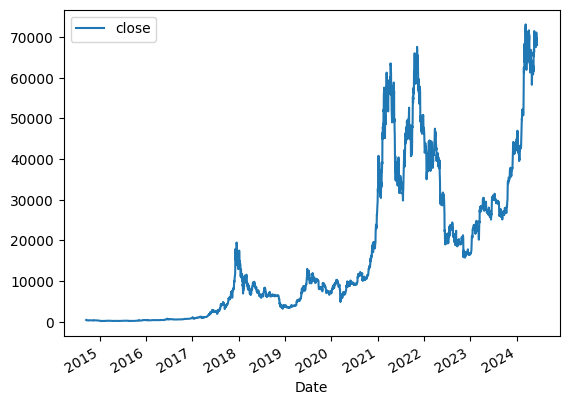

In [6]:
btc.plot.line(y="close", use_index=True)

In [7]:
# Extract features and target variable
X = btc.drop(columns=['close'])  # Drop the 'close' column
y = btc['close']

In [8]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# Reshape data for LSTM input (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [11]:
# Define LSTM model
model = Sequential()
model.add(LSTM(50,activation = 'relu', return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.compile(optimizer='adam', loss='mse')

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
# Train LSTM model
callback = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[callback], verbose=1)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 434999584.0000 - val_loss: 1364296704.0000
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 402953824.0000 - val_loss: 240590128.0000
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49973508.0000 - val_loss: 15351517.0000
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23798960.0000 - val_loss: 14197321.0000
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19292758.0000 - val_loss: 11914322.0000
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22039964.0000 - val_loss: 7182944.5000
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21230528.0000 - val_loss: 15228457.0000
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20900646.0000 - val_loss: 10186795.0000
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20420106.0000 - val_loss: 8044544.0000


In [13]:
# Evaluate model
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6677219.0000 
Test Loss: 8044544.0


In [15]:
# Make predictions
predictions = model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test, predictions)
print("R-squared:", r_squared)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
R-squared: 0.9683757869746604


In [16]:
# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 8044544.204520028
